# DSTL Satellite Imagery Feature Detection


In [1]:
#TODO: CORRECT UTILS FUNCTION TO INCLUDE INTERIOR
# WRITE UP DATA EXP

In [1]:
import pandas as pd
import rasterio
from rasterio import mask as raster_mask
import geopandas as gpd
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import os
from rasterio import plot as rplot
import numpy as np
import glob
import shapely
from shapely import speedups

speedups.disable()

%matplotlib inline

In [2]:
import utils

In [9]:
grid_sizes = utils.get_grid_sizes()

Three Band size: H:3349, W:3391
Sixteen Band size: H:3348, W:3391
Three Band size: H:3349, W:3391
Sixteen Band size: H:3348, W:3391
Three Band size: H:3349, W:3391
Sixteen Band size: H:3348, W:3391
Three Band size: H:3349, W:3391
Sixteen Band size: H:3348, W:3391
Three Band size: H:3349, W:3387
Sixteen Band size: H:3348, W:3388


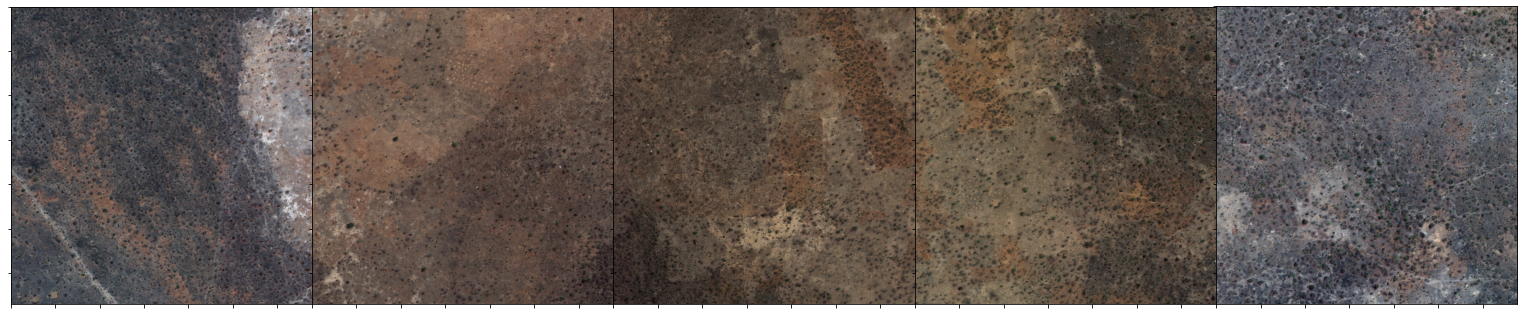

In [10]:
#image files

base = '6040'
base_names = []
for i in range(5):
    row = i
    for j in range(5):
        col = j
        base_names.append(base+'_'+str(row)+'_'+str(col)+'.tif')

fig, axes = plt.subplots(1,5,figsize=(27,7))

plt.subplots_adjust(wspace=0, hspace=0)

for i,file in enumerate(base_names[0:5]):
    image = rasterio.open(os.path.join('three_band',file))
    image_16 = rasterio.open(os.path.join('sixteen_band',file[:-4]+'_P.tif'))
    print(f"Three Band size: H:{image.height}, W:{image.width}")
    print(f"Sixteen Band size: H:{image_16.height}, W:{image_16.width}")
    scaled_image = utils.scale_pixels(image)
    
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    
    rplot.show(scaled_image,ax=axes[i])
    image.close()
    image_16.close()
    

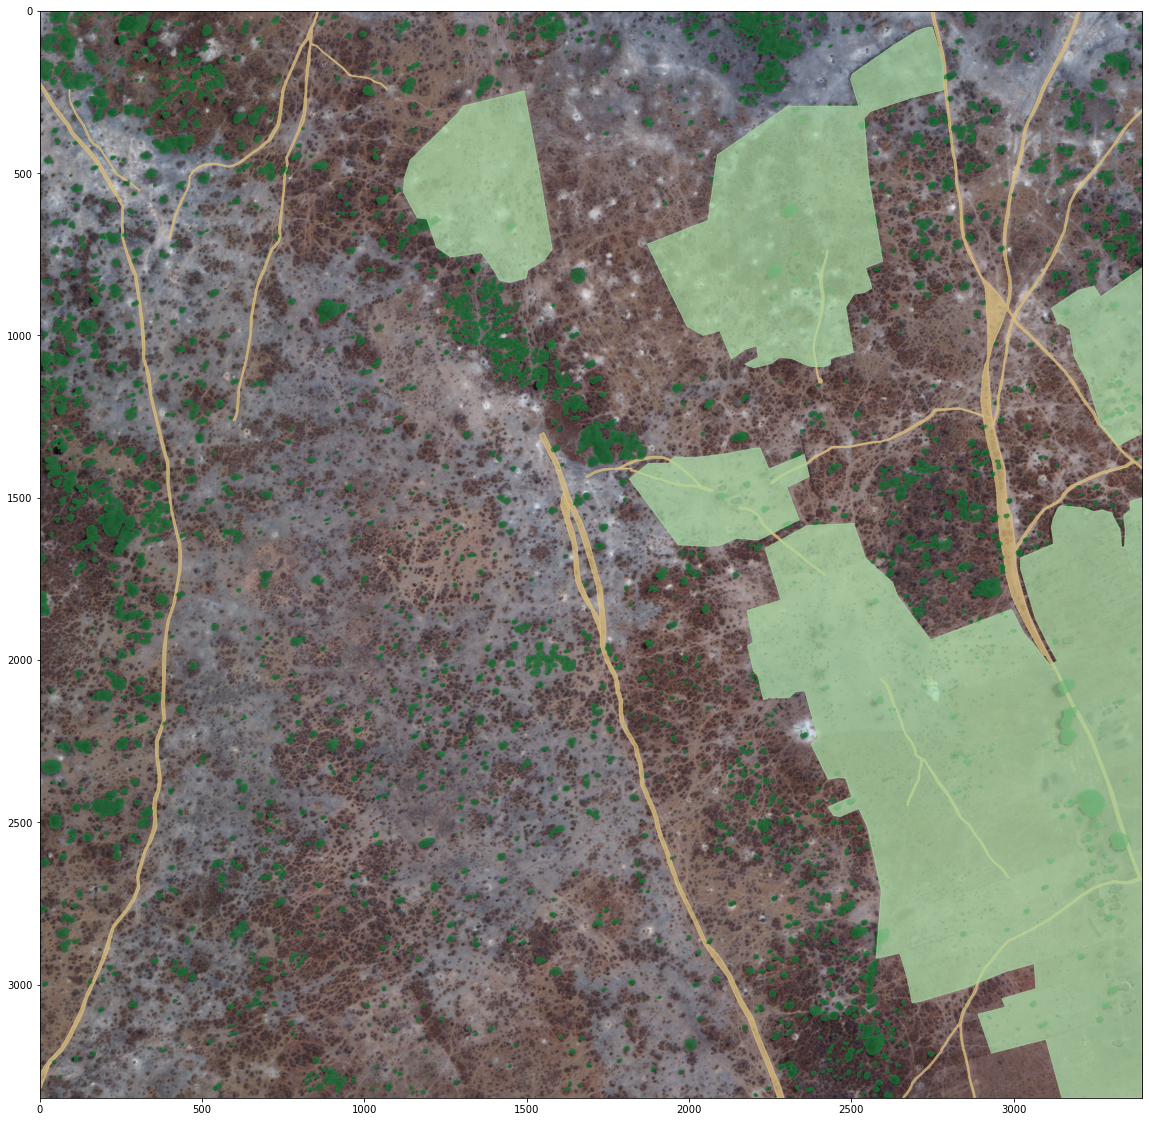

In [11]:
image_id = '6010_1_2'

test_img = rasterio.open(os.path.join('three_band',image_id+'.tif'))
scaled_test = utils.scale_pixels(test_img)

test_poly = utils.get_labeled_polygons(image_id, grid_sizes)

fig, ax = plt.subplots(1,figsize=(20,20))
utils.plot_polys(test_poly,axes=ax)
rplot.show(scaled_test,ax=ax)
test_img.close()

C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


6040_1_1: is not a training image
no polygons to plot
6040_1_2: is not a training image
no polygons to plot


C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


6040_1_4: is not a training image
no polygons to plot


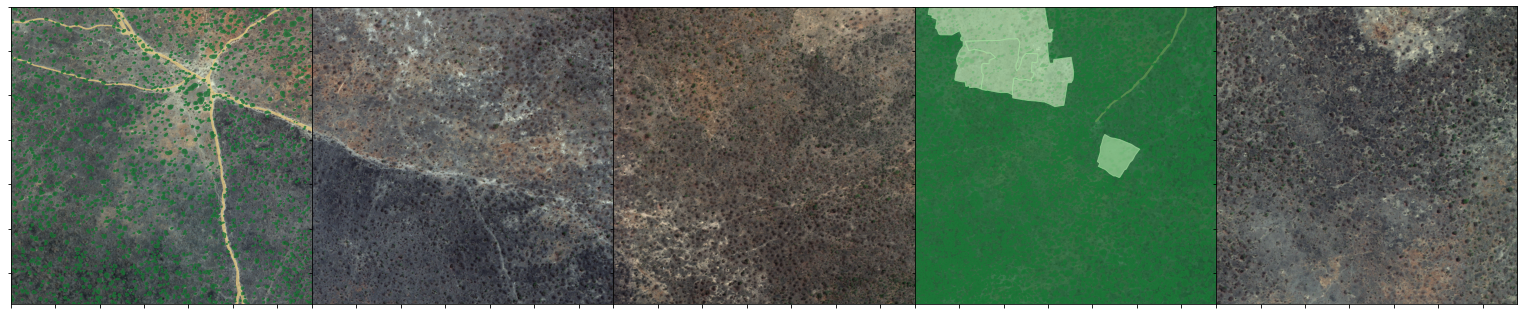

In [12]:
fig, axes = plt.subplots(1,5,figsize=(27,7))

plt.subplots_adjust(wspace=0, hspace=0)

for i,file in enumerate(base_names[5:10]):
    image = rasterio.open(os.path.join('three_band',file))
    scaled_image = utils.scale_pixels(image)
    
    poly = utils.get_labeled_polygons(file[:-4], grid_sizes)
    if bool(poly):
        gdf_list = []
        for key in list(poly.keys()):
            df = pd.DataFrame()
            df['geometry'] = poly[key]
            df['class_type'] = key

            gdf_list.append(df)

    concat = gpd.GeoDataFrame(pd.concat(gdf_list,ignore_index=True))
    concat.crs = "EPSG:4326"
    concat['geometry'] = concat['geometry'].affine_transform([1, 0, 0, -1, 0, 0])
    concat.to_file(os.path.join('gdf',f'gdf_{i}.shp'))
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    
    utils.plot_polys(poly,axes=axes[i])
    
    rplot.show(scaled_image,ax=axes[i])
    image.close()

In [ ]:
### Explore training file

In [13]:
wkt_train = pd.read_csv('train_wkt_v4.csv')

wkt_train['MultipolygonWKT'] = wkt_train['MultipolygonWKT'].apply(shapely.wkt.loads)

In [14]:
train_gpd = gpd.GeoDataFrame(wkt_train,geometry='MultipolygonWKT')

train_gpd.rename({'MultipolygonWKT':'geometry'},axis=1,inplace=True)

In [37]:
train_gpd['dummy_geo'] = 0
train_gpd['dummy_geo'] = train_gpd['dummy_geo'].astype('object')
train_gpd['mask'] = np.nan

for index, row in train_gpd.iterrows():   

    image_id = row['ImageId']
    img = rasterio.open(os.path.join('three_band',image_id+'.tif'))
    
    W,H = utils.get_image_scale(img)
    
    
    xmax, ymax = utils.get_image_max(image_id, grid_sizes)
    
    geo = row['geometry']
    if str(geo) == "GEOMETRY COLLECTION EMPTY" or str(geo) == 'MULTIPOLYGON EMPTY':
        train_gpd.at[index,'geometry'] = np.nan
        
   
    else:

        polys = []
        for poly in geo:
            
            x_ext,y_ext = np.array(poly.exterior.coords.xy[0]), np.array(poly.exterior.coords.xy[1])
            exterior = utils.convert_xy_to_raster(x_ext,y_ext,xmax,ymax,W,H)
            interiors = []
            for interior in poly.interiors:
                x_int, y_int = np.array(interior.coords.xy[0]),np.array(interior.coords.xy[1])
                interiors.append(utils.convert_xy_to_raster(x_int, y_int,xmax,ymax,W,H))

            scaled_poly = shapely.geometry.Polygon(exterior,interiors)
            
            polys.append(scaled_poly)
        
        polygon_val = shapely.geometry.MultiPolygon(polys)
        train_gpd.at[index,'dummy_geo'] = polygon_val 
        mask = raster_mask.mask(img,polygon_val)[0]
        classtype = row['ClassType']
        np.concatenate(classtype,mask)
    img.close()
    
    
train_gpd.set_geometry('dummy_geo',inplace=True)
train_gpd.drop('geometry',axis=1,inplace=True)
# train_gpd.rename({'dummy_geo':'geometry'},axis=1,inplace=True)

ValueError: setting an array element with a sequence.

In [ ]:
train_gpd['area'] = train_gpd.area.astype('float32')
train_gpd.groupby('ClassType')['area'].sum().plot.bar()


In [ ]:
train_gpd.to_file('train_gdf.geojson',driver='GeoJSON')


In [23]:
### Sixteen Band

img_id = '6010_0_0'
band_suffix = ['A','M','P']

C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


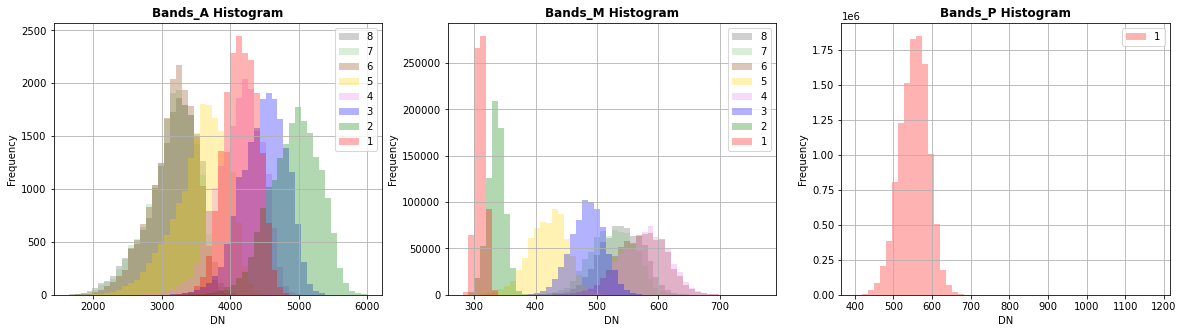

In [27]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

for i,band in enumerate(band_suffix):
    with rasterio.open(os.path.join('sixteen_band',img_id+"_"+band+'.tif')) as img:
        rasterio.plot.show_hist(img, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Bands_"+band+" Histogram",ax=axes[i])


In [36]:
all_image_ids = glob.glob('three_band/*.tif')
all_image_ids = [x.replace('three_band\\','').replace('.tif','') for x in all_image_ids]

In [46]:
len(all_image_ids)

450

In [40]:
n = ['A','M','P']

df_dict = {}
for img in all_image_ids:
    for name in n:
        key = img+"_"+name
        file = key+'.tif'
        with rasterio.open(os.path.join('sixteen_band',file)) as f:
            df_dict[key] = f.tags()
        


C:\ProgramData\Miniconda3\envs\gis_test\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [41]:
df_16 = pd.DataFrame(df_dict).T

In [42]:
df_16['TIFFTAG_IMAGEDESCRIPTION'] = df_16['TIFFTAG_IMAGEDESCRIPTION'].str.replace('{','').str.replace('[','')\
.str.replace(' ','').str.replace('\n','').str.replace(']','').str.replace('}','').str.replace('bandList=','')\
.str.split(';')

In [43]:
df_16['TIFFTAG_IMAGEDESCRIPTION'] = df_16['TIFFTAG_IMAGEDESCRIPTION'].apply(lambda x: x[:-1])

In [54]:
df_16.loc[df_16['TIFFTAG_DATETIME']=='2016:03:30 20:44:13']

TIFFTAG_COPYRIGHT  \
6080_0_0_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_0_1_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_0_2_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_0_3_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_0_4_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_1_0_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_1_1_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_1_2_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_1_3_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_1_4_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_2_0_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_2_1_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_2_2_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_2_3_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_2_4_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_3_0_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_3_1_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_3_2_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_3_3_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_3_4_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_4_0_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_4_1_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_4_2_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_4_3_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6080_4_4_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   

               TIFFTAG_DATETIME  TIFFTAG_IMAGEDESCRIPTION  \
6080_0_0_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_0_1_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_0_2_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_0_3_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_0_4_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_1_0_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_1_1_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_1_2_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_1_3_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_1_4_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_2_0_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_2_1_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_2_2_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_2_3_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_2_4_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_3_0_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_3_1_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_3_2_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_3_3_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_3_4_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_4_0_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_4_1_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_4_2_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_4_3_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   
6080_4_4_M  2016:03:30 20:44:13  [6, 2, 3, 7, 4, 8, 5, 9]   

           TIFFTAG_MAXSAMPLEVALUE TIFFTAG_MINSAMPLEVALUE  
6080_0_0_M                   2047                      1  
6080_0_1_M                   2047                      1  
6080_0_2_M                   2047                      1  
6080_0_3_M                   2047                      1  
6080_0_4_M                   2047                      1  
6080_1_0_M                   2047                      1  
6080_1_1_M                   2047                      1  
6080_1_2_M                   2047                      1  
6080_1_3_M                   2047                      1  
6080_1_4_M                   2047                      1  
6080_2_0_M                   2047                      1  
6080_2_1_M                   2047                      1  

In [56]:
df_16.groupby('TIFFTAG_DATETIME').head()

TIFFTAG_COPYRIGHT  \
6010_0_0_A  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6010_0_0_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6010_0_0_P  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6010_0_1_A  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6010_0_1_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
...                                                       ...   
6180_0_3_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6180_0_3_P  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6180_0_4_A  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6180_0_4_M  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   
6180_0_4_P  (C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmon...   

               TIFFTAG_DATETIME          TIFFTAG_IMAGEDESCRIPTION  \
6010_0_0_A  2016:03:30 20:00:05  [10, 11, 12, 13, 14, 15, 16, 17]   
6010_0_0_M  2016:03:30 19:57:53          [6, 2, 3, 7, 4, 8, 5, 9]   
6010_0_0_P  2016:03:30 19:57:46                               [1]   
6010_0_1_A  2016:03:30 20:00:05  [10, 11, 12, 13, 14, 15, 16, 17]   
6010_0_1_M  2016:03:30 19:57:53          [6, 2, 3, 7, 4, 8, 5, 9]   
...                         ...                               ...   
6180_0_3_M  2016:03:30 19:58:12          [6, 2, 3, 7, 4, 8, 5, 9]   
6180_0_3_P  2016:03:30 19:58:09                               [1]   
6180_0_4_A  2016:03:30 20:00:57  [10, 11, 12, 13, 14, 15, 16, 17]   
6180_0_4_M  2016:03:30 19:58:12          [6, 2, 3, 7, 4, 8, 5, 9]   
6180_0_4_P  2016:03:30 19:58:09                               [1]   

           TIFFTAG_MAXSAMPLEVALUE TIFFTAG_MINSAMPLEVALUE  
6010_0_0_A                   6249                   1254  
6010_0_0_M                    799                    269  
6010_0_0_P                   1420                      0  
6010_0_1_A                   6249                   1254  
6010_0_1_M                    799                    269  
...                           ...                    ...  
6180_0_3_M                    817                    248  
6180_0_3_P                    771                      0  
6180_0_4_A                   6051                   1091  
6180_0_4_M                    817                    248  
6180_0_4_P                    771                      0  

[270 rows x 5 columns]

In [45]:
df_16.value_counts("TIFFTAG_DATETIME")

TIFFTAG_DATETIME
2016:03:30 20:44:13    25
2016:03:30 19:51:57    25
2016:03:30 19:57:40    25
2016:03:30 19:57:30    25
2016:03:30 19:57:11    25
2016:03:30 19:57:09    25
2016:03:30 19:55:10    25
2016:03:30 19:55:07    25
2016:03:30 19:52:45    25
2016:03:30 19:52:37    25
2016:03:30 19:52:21    25
2016:03:30 19:52:18    25
2016:03:30 19:52:16    25
2016:03:30 19:51:43    25
2016:03:30 20:44:10    25
2016:03:30 19:51:41    25
2016:03:30 19:51:40    25
2016:03:30 19:51:38    25
2016:03:30 19:51:35    25
2016:03:30 19:50:18    25
2016:03:30 19:50:16    25
2016:03:30 19:49:49    25
2016:03:30 19:27:44    25
2016:03:30 19:27:41    25
2016:03:30 19:22:54    25
2016:03:30 19:22:51    25
2016:03:30 19:57:46    25
2016:03:30 19:57:53    25
2016:03:30 19:58:01    25
2016:03:30 19:58:04    25
2016:03:30 20:43:58    25
2016:03:30 20:40:36    25
2016:03:30 20:40:34    25
2016:03:30 20:40:11    25
2016:03:30 20:37:44    25
2016:03:30 20:37:42    25
2016:03:30 20:37:33    25
2016:03:30 20:37:24  

In [25]:
image_id = '6010_1_2'

test_img_16_M = rasterio.open(os.path.join('sixteen_band',image_id+'_M.tif'))
test_img_16_P = rasterio.open(os.path.join('sixteen_band',image_id+'_P.tif'))
test_img_16_A = rasterio.open(os.path.join('sixteen_band',image_id+'_A.tif'))
test_img_3 = rasterio.open(os.path.join('three_band',image_id+'.tif'))

In [29]:
print(test_img_16_M.shape)
print(test_img_16_P.shape)
print(test_img_16_A.shape)
print(test_img_3.shape)

(837, 849)
(3348, 3396)
(134, 136)
(3349, 3396)


In [32]:
print(np.array(test_img_16_M.read().T).shape)

(849, 837, 8)


In [9]:
test_img_16_nd = test_img_16_M.read(out_shape=(test_img_13.height,test_img_13.width))

In [15]:
test_img_13.read().shape

(3, 3349, 3396)

In [19]:
type(test_img_13.read())

numpy.ndarray

In [18]:
type(test_img_16_nd)

numpy.ndarray

In [23]:
np.concatenate([test_img_16_nd,test_img_13.read()]).shape

(11, 3349, 3396)

In [29]:
# help(test_img_16_M)

In [30]:
# t_M = test_img_16_M.transform
# t_A = test_img_16_A.transform

# old_height = test_img_16_M.height
# old_width = test_img_16_M.width

# new_height = test_img_16_P.height
# new_width = test_img_16_P.width

In [31]:
test_img_16_M_nd = test_img_16_M.read(out_shape=(int(test_img_16_P.height), int(test_img_16_P.width)))

In [32]:
# def resize_image(src_img, scaled_img):
#     t = src_img.transform
#     old_height = src_img.height
#     old_width = src_img.width
    
#     new_height = scaled_img.height
#     new_width = scaled_img.width
    
#     y_scale = new_height / old_height
#     x_scale = new_width / old_width
    
#     transformation = rasterio.Affine(t.a * x_scale, t.b,t.c,t.d,t.e * y_scale, t.f)
    
    
    

In [35]:
img_scaled = np.empty(test_img_16_M_nd.shape)
for i,band in enumerate(test_img_16_M_nd):
    img_max = np.max(band)
    img_min = np.min(band)

    scaled_band = (band - img_min) * 1/(img_max-img_min)

    img_scaled[i] = scaled_band


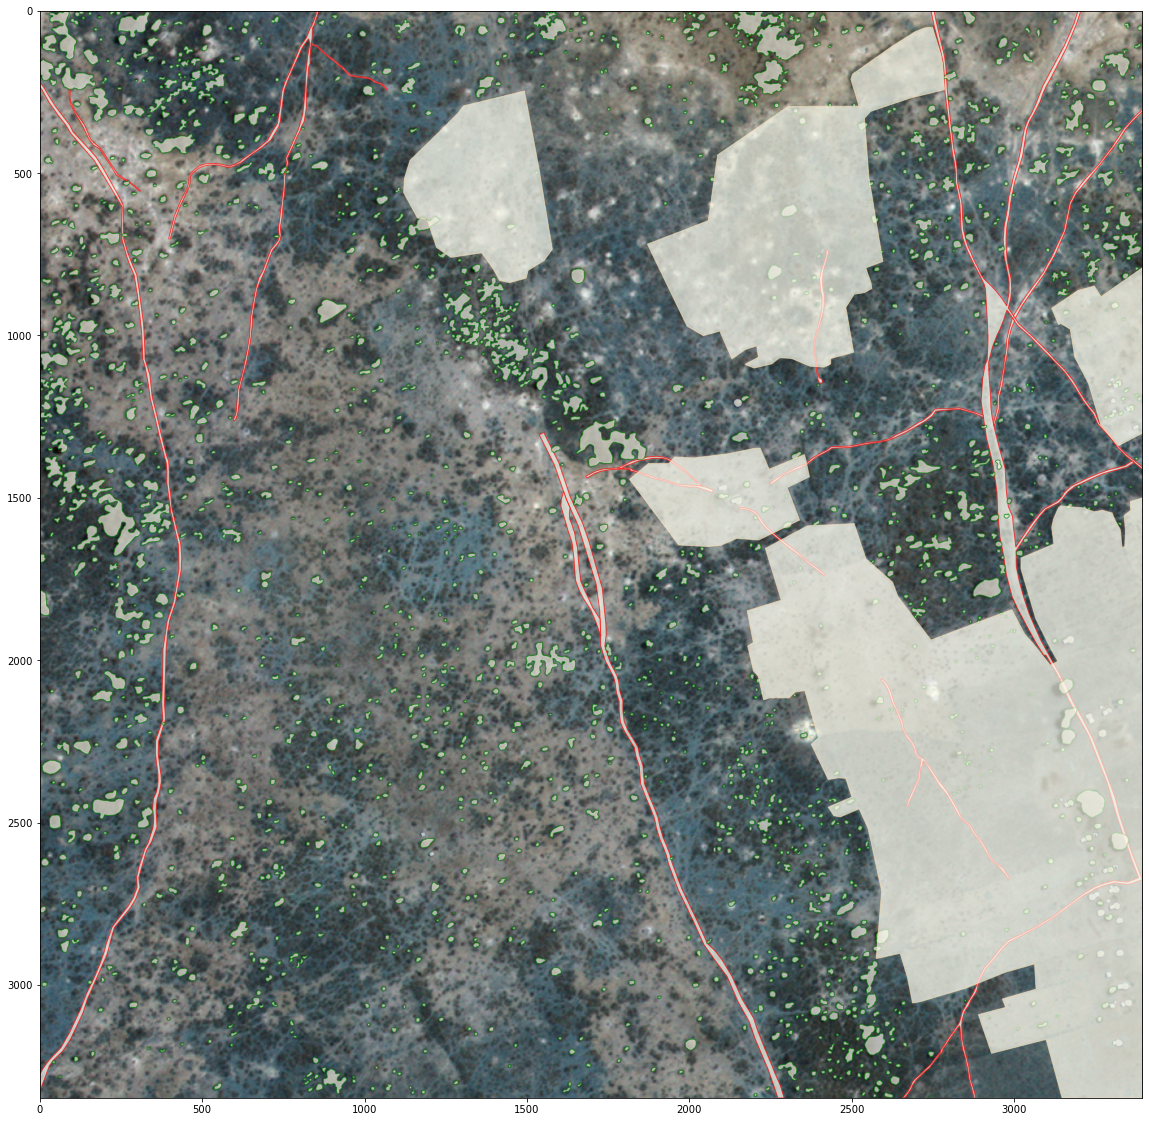

In [37]:
# scaled_test = utils.scale_image(test_img_16_M)

test_poly = utils.get_labeled_polygons(image_id, grid_sizes)

fig, ax = plt.subplots(1,figsize=(20,20))
utils.plot_polys(test_poly,axes=ax)
rplot.show(img_scaled[0:3],ax=ax)
# test_img_16.close()

In [24]:
test_img_16_M.close()
test_img_16_P.close()
test_img_16_A.close()

In [50]:
image_id = '6010_1_2'

test_img = rasterio.open(os.path.join('three_band',image_id+'.tif'))
scaled_test = utils.scale_pixels(test_img)

test_poly = utils.get_labeled_polygons(image_id, grid_sizes)

c:\program files\python38\lib\site-packages\rasterio\__init__.py:229: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [48]:
gdf_test = gpd.read_file('train_gdf.geojson')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


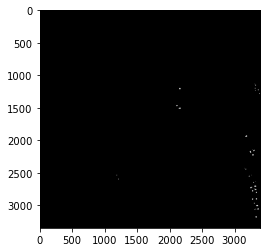

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


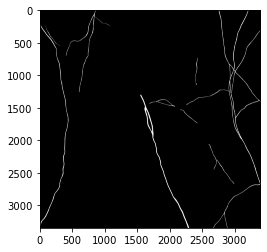

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


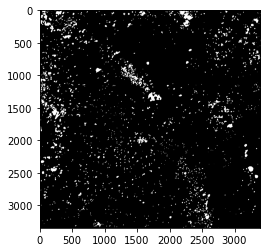

In [79]:
# fig, axes = plt.subplots(1,3,figsize=(21,7))

for i,geo in enumerate(gdf_test.loc[(gdf_test['ImageId']==image_id) & (gdf_test['geometry']!=None)]['geometry']):

    r_mask = mask.mask(test_img,geo)
    print(type(r_mask[0]))
    rplot.show(r_mask[0])

In [51]:
first_mask = raster_mask.mask(test_img,gdf_test.loc[(gdf_test['ImageId']==image_id) & (gdf_test['ClassType']==2)]['geometry'].values)

In [55]:
print(type(first_mask[0]))

<class 'numpy.ndarray'>


In [56]:
print(type(np.array(1)))

<class 'numpy.ndarray'>


In [54]:
print(np.concatenate(np.array(1),first_mask[0]))

TypeError: dispatcher for __array_function__ did not return an iterable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


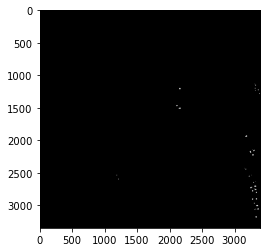

In [62]:
rplot.show(first_mask[0])

In [57]:
test_img.close()

In [57]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


ModuleNotFoundError: No module named 'tensorflow_datasets'